In [1]:
# GENERAL
import math
import os
import splitfolders
import numpy as np
# PYTORCH
import torch
from torch import optim, nn, utils, Tensor
from torch.utils.data import random_split,  DataLoader
from torch.optim.lr_scheduler import LambdaLR
import torch.nn as nn
import torch.nn.functional as F
# TORCHMETRICS & TORCHVISION & TORCHSUMMARY
import torchmetrics
from torchvision import datasets, transforms
from torchvision.transforms import Compose, Normalize, Resize, ToTensor, RandAugment
from torchsummary import summary
# LIGHTNING MODULE
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import LearningRateMonitor, RichProgressBar
# HUGGINGFACE UTILITIES
from datasets import load_dataset
import evaluate
from transformers import ViTFeatureExtractor, ViTForImageClassification, TrainingArguments, Trainer
# PLOTTING & LOGGING
import matplotlib as plt
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,accuracy_score
import wandb

In [2]:
# Set the device to Apple Silicon M1 chip
device = torch.device('mps')

In [3]:
# Define general parameters
batch_size = 64
img_height = 224
img_width = 224
learning_rate = 2e-4
epochs = 10
num_classes = 3

In [5]:
dataset = load_dataset("imagefolder", data_dir="./FireData", drop_labels=False)

dataset.push_to_hub("Shravanig/fire_detection_final")

Resolving data files:   0%|          | 0/6060 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/756 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/759 [00:00<?, ?it/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/6060 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/61 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/756 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/8 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/759 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/8 [00:00<?, ?ba/s]

In [4]:
# Download the dataset from the Hub
ds = load_dataset("Shravanig/fire_detection_final")
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 6060
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 756
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 759
    })
})

Label: 0


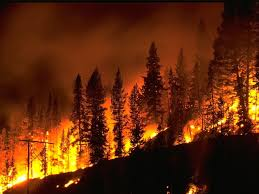

In [5]:
# Pick a sample from the dataset
ex = ds['train'][667]
print("Label: " + str(ex['label']))
ex['image']

In [6]:
# Define the model to use and the feature extractor
model_name = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)

C:\Users\shrav\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [7]:
# Print shape of the tensor of a sample image
sample_tensor = feature_extractor(ex['image'], return_tensors='pt')
sample_tensor['pixel_values'].shape

torch.Size([1, 3, 224, 224])

In [8]:
# Define a normalizer
normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)

# Define the transformation to apply to the images from train and val samples
_train_transforms = Compose(
        [
            Resize((feature_extractor.size['width'],feature_extractor.size['height'])),
            RandAugment(num_ops=2, magnitude=9),
            ToTensor(),
            normalize
        ]
    )

_val_transforms = Compose(
        [
            Resize((feature_extractor.size['width'],feature_extractor.size['height'])),
            ToTensor(),
            normalize
        ]
    )

# Define the actual function that applies the transformations to the samples
def train_transforms(batch):
    batch['pixel_values'] = [_train_transforms(x.convert("RGB")) for x in batch['image']]
    return batch

def val_transforms(batch):
    batch['pixel_values'] = [_val_transforms(x.convert("RGB")) for x in batch['image']]
    return batch

In [9]:
# Apply the transformations to the samples. Note that the set_transform() functions modifies in-place.
ds['train'].set_transform(train_transforms)
ds['validation'].set_transform(val_transforms)
ds['test'].set_transform(val_transforms)

In [10]:
# Define the data collator
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }

In [11]:
# Copyright 2020 The HuggingFace Datasets Authors and the current dataset script contributor.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
"""Accuracy metric."""

import datasets
from sklearn.metrics import accuracy_score

import evaluate


_DESCRIPTION = """
Accuracy is the proportion of correct predictions among the total number of cases processed. It can be computed with:
Accuracy = (TP + TN) / (TP + TN + FP + FN)
 Where:
TP: True positive
TN: True negative
FP: False positive
FN: False negative
"""


_KWARGS_DESCRIPTION = """
Args:
    predictions (`list` of `int`): Predicted labels.
    references (`list` of `int`): Ground truth labels.
    normalize (`boolean`): If set to False, returns the number of correctly classified samples. Otherwise, returns the fraction of correctly classified samples. Defaults to True.
    sample_weight (`list` of `float`): Sample weights Defaults to None.

Returns:
    accuracy (`float` or `int`): Accuracy score. Minimum possible value is 0. Maximum possible value is 1.0, or the number of examples input, if `normalize` is set to `True`.. A higher score means higher accuracy.

Examples:

    Example 1-A simple example
        >>> accuracy_metric = evaluate.load("accuracy")
        >>> results = accuracy_metric.compute(references=[0, 1, 2, 0, 1, 2], predictions=[0, 1, 1, 2, 1, 0])
        >>> print(results)
        {'accuracy': 0.5}

    Example 2-The same as Example 1, except with `normalize` set to `False`.
        >>> accuracy_metric = evaluate.load("accuracy")
        >>> results = accuracy_metric.compute(references=[0, 1, 2, 0, 1, 2], predictions=[0, 1, 1, 2, 1, 0], normalize=False)
        >>> print(results)
        {'accuracy': 3.0}

    Example 3-The same as Example 1, except with `sample_weight` set.
        >>> accuracy_metric = evaluate.load("accuracy")
        >>> results = accuracy_metric.compute(references=[0, 1, 2, 0, 1, 2], predictions=[0, 1, 1, 2, 1, 0], sample_weight=[0.5, 2, 0.7, 0.5, 9, 0.4])
        >>> print(results)
        {'accuracy': 0.8778625954198473}
"""


_CITATION = """
@article{scikit-learn,
  title={Scikit-learn: Machine Learning in {P}ython},
  author={Pedregosa, F. and Varoquaux, G. and Gramfort, A. and Michel, V.
         and Thirion, B. and Grisel, O. and Blondel, M. and Prettenhofer, P.
         and Weiss, R. and Dubourg, V. and Vanderplas, J. and Passos, A. and
         Cournapeau, D. and Brucher, M. and Perrot, M. and Duchesnay, E.},
  journal={Journal of Machine Learning Research},
  volume={12},
  pages={2825--2830},
  year={2011}
}
"""


@evaluate.utils.file_utils.add_start_docstrings(_DESCRIPTION, _KWARGS_DESCRIPTION)
class Accuracy(evaluate.Metric):
    def _info(self):
        return evaluate.MetricInfo(
            description=_DESCRIPTION,
            citation=_CITATION,
            inputs_description=_KWARGS_DESCRIPTION,
            features=datasets.Features(
                {
                    "predictions": datasets.Sequence(datasets.Value("int32")),
                    "references": datasets.Sequence(datasets.Value("int32")),
                }
                if self.config_name == "multilabel"
                else {
                    "predictions": datasets.Value("int32"),
                    "references": datasets.Value("int32"),
                }
            ),
            reference_urls=["https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html"],
        )

    def _compute(self, predictions, references, normalize=True, sample_weight=None):
        return {
            "accuracy": float(
                accuracy_score(references, predictions, normalize=normalize, sample_weight=sample_weight)
            )
        }


In [12]:
# Copyright 2020 The HuggingFace Datasets Authors and the current dataset script contributor.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
"""F1 metric."""

import datasets
from sklearn.metrics import f1_score

import evaluate


_DESCRIPTION = """
The F1 score is the harmonic mean of the precision and recall. It can be computed with the equation:
F1 = 2 * (precision * recall) / (precision + recall)
"""


_KWARGS_DESCRIPTION = """
Args:
    predictions (`list` of `int`): Predicted labels.
    references (`list` of `int`): Ground truth labels.
    labels (`list` of `int`): The set of labels to include when `average` is not set to `'binary'`, and the order of the labels if `average` is `None`. Labels present in the data can be excluded, for example to calculate a multiclass average ignoring a majority negative class. Labels not present in the data will result in 0 components in a macro average. For multilabel targets, labels are column indices. By default, all labels in `predictions` and `references` are used in sorted order. Defaults to None.
    pos_label (`int`): The class to be considered the positive class, in the case where `average` is set to `binary`. Defaults to 1.
    average (`string`): This parameter is required for multiclass/multilabel targets. If set to `None`, the scores for each class are returned. Otherwise, this determines the type of averaging performed on the data. Defaults to `'binary'`.

        - 'binary': Only report results for the class specified by `pos_label`. This is applicable only if the classes found in `predictions` and `references` are binary.
        - 'micro': Calculate metrics globally by counting the total true positives, false negatives and false positives.
        - 'macro': Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.
        - 'weighted': Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). This alters `'macro'` to account for label imbalance. This option can result in an F-score that is not between precision and recall.
        - 'samples': Calculate metrics for each instance, and find their average (only meaningful for multilabel classification).
    sample_weight (`list` of `float`): Sample weights Defaults to None.

Returns:
    f1 (`float` or `array` of `float`): F1 score or list of f1 scores, depending on the value passed to `average`. Minimum possible value is 0. Maximum possible value is 1. Higher f1 scores are better.

Examples:

    Example 1-A simple binary example
        >>> f1_metric = evaluate.load("f1")
        >>> results = f1_metric.compute(references=[0, 1, 0, 1, 0], predictions=[0, 0, 1, 1, 0])
        >>> print(results)
        {'f1': 0.5}

    Example 2-The same simple binary example as in Example 1, but with `pos_label` set to `0`.
        >>> f1_metric = evaluate.load("f1")
        >>> results = f1_metric.compute(references=[0, 1, 0, 1, 0], predictions=[0, 0, 1, 1, 0], pos_label=0)
        >>> print(round(results['f1'], 2))
        0.67

    Example 3-The same simple binary example as in Example 1, but with `sample_weight` included.
        >>> f1_metric = evaluate.load("f1")
        >>> results = f1_metric.compute(references=[0, 1, 0, 1, 0], predictions=[0, 0, 1, 1, 0], sample_weight=[0.9, 0.5, 3.9, 1.2, 0.3])
        >>> print(round(results['f1'], 2))
        0.35

    Example 4-A multiclass example, with different values for the `average` input.
        >>> predictions = [0, 2, 1, 0, 0, 1]
        >>> references = [0, 1, 2, 0, 1, 2]
        >>> results = f1_metric.compute(predictions=predictions, references=references, average="macro")
        >>> print(round(results['f1'], 2))
        0.27
        >>> results = f1_metric.compute(predictions=predictions, references=references, average="micro")
        >>> print(round(results['f1'], 2))
        0.33
        >>> results = f1_metric.compute(predictions=predictions, references=references, average="weighted")
        >>> print(round(results['f1'], 2))
        0.27
        >>> results = f1_metric.compute(predictions=predictions, references=references, average=None)
        >>> print(results)
        {'f1': array([0.8, 0. , 0. ])}

    Example 5-A multi-label example
        >>> f1_metric = evaluate.load("f1", "multilabel")
        >>> results = f1_metric.compute(predictions=[[0, 1, 1], [1, 1, 0]], references=[[0, 1, 1], [0, 1, 0]], average="macro")
        >>> print(round(results['f1'], 2))
        0.67
"""


_CITATION = """
@article{scikit-learn,
    title={Scikit-learn: Machine Learning in {P}ython},
    author={Pedregosa, F. and Varoquaux, G. and Gramfort, A. and Michel, V.
           and Thirion, B. and Grisel, O. and Blondel, M. and Prettenhofer, P.
           and Weiss, R. and Dubourg, V. and Vanderplas, J. and Passos, A. and
           Cournapeau, D. and Brucher, M. and Perrot, M. and Duchesnay, E.},
    journal={Journal of Machine Learning Research},
    volume={12},
    pages={2825--2830},
    year={2011}
}
"""


@evaluate.utils.file_utils.add_start_docstrings(_DESCRIPTION, _KWARGS_DESCRIPTION)
class F1(evaluate.Metric):
    def _info(self):
        return evaluate.MetricInfo(
            description=_DESCRIPTION,
            citation=_CITATION,
            inputs_description=_KWARGS_DESCRIPTION,
            features=datasets.Features(
                {
                    "predictions": datasets.Sequence(datasets.Value("int32")),
                    "references": datasets.Sequence(datasets.Value("int32")),
                }
                if self.config_name == "multilabel"
                else {
                    "predictions": datasets.Value("int32"),
                    "references": datasets.Value("int32"),
                }
            ),
            reference_urls=["https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html"],
        )

    def _compute(self, predictions, references, labels=None, pos_label=1, average="binary", sample_weight=None):
        score = f1_score(
            references, predictions, labels=labels, pos_label=pos_label, average=average, sample_weight=sample_weight
        )
        return {"f1": float(score) if score.size == 1 else score}

In [13]:
# Define the function that will compute precision and recall (metrics)
def compute_metrics(eval_pred):
    metric1 = evaluate.load("precision")
    metric2 = evaluate.load("recall")
    metric3 = evaluate.load("accuracy")
    metric4 = evaluate.load("f1")
    #metric5 = evaluate.load("roc_auc")
    preds = np.argmax(eval_pred.predictions, axis=1)
    labels = eval_pred.label_ids

    precision = metric1.compute(predictions=preds, references=labels, average="weighted")["precision"]
    recall = metric2.compute(predictions=preds, references=labels, average="weighted")["recall"]
    accuracy = metric3.compute(predictions=preds, references=labels)["accuracy"]
    f1score = metric4.compute(predictions=preds, references=labels, average="weighted")["f1"]
    #roc_auc = metric5.compute(prediction_scores=preds, references=labels, average="weighted")["roc_auc"]

    return {"precision": precision, "recall": recall, "accuracy": accuracy,"f1score":f1score}


In [14]:
# Load a pretrained model --> vit-base-patch16-224-in21k and define classes and labels
model = ViTForImageClassification.from_pretrained(
    model_name,
    num_attention_heads=8,
    num_labels = num_classes,
    id2label = {0:'Fire', 1:'Normal', 2:'Smoke'},
    label2id = {'Fire':0, 'Normal':1, 'Smoke':2})

model.to('cpu')

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [15]:
print("number Of attention heads: ",model.config.num_attention_heads)

number Of attention heads:  8


In [16]:
# default uses adamW optimizer
training_args = TrainingArguments(
  output_dir="Shravanig/vit-fire-detection",
  per_device_train_batch_size=batch_size,
  per_device_eval_batch_size=batch_size,
  evaluation_strategy="epoch",
  save_strategy="epoch",
  logging_steps=50,
  num_train_epochs=epochs,

  learning_rate=learning_rate,
  weight_decay=0.01,
  adam_beta1=0.9,
  adam_beta2=0.999,
  adam_epsilon=1e-8,
  warmup_steps=100,

  save_total_limit=1,
  remove_unused_columns=False,
  push_to_hub="end", #set to "end" and call save_model()
  report_to=None,
  load_best_model_at_end=True
)

In [17]:
# Define the Trainer and set the parameters
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=ds["train"],
    eval_dataset=ds["validation"],
    tokenizer=feature_extractor
)

In [18]:
# Traine the model logging metrics and reporting to WanDB.
train_results = trainer.train()
trainer.log_metrics("train", train_results.metrics)
trainer.log_metrics("eval", train_results.metrics)
wandb.finish()

wandb: Currently logged in as: shravanig6363. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Precision,Recall,Accuracy,F1score
1,0.590600,0.059412,0.985495,0.985450,0.985450,0.985449
2,0.081200,0.044709,0.990787,0.990741,0.990741,0.990740
3,0.057500,0.077926,0.977778,0.976190,0.976190,0.976160
4,0.036000,0.024204,0.993515,0.993386,0.993386,0.993386
5,0.039500,0.028332,0.992145,0.992063,0.992063,0.992063
6,0.022500,0.016911,0.994709,0.994709,0.994709,0.994709
7,0.016500,0.020455,0.993391,0.993386,0.993386,0.993386
8,0.009900,0.018024,0.996037,0.996032,0.996032,0.996032
9,0.007400,0.025498,0.994730,0.994709,0.994709,0.994709
10,0.005500,0.024957,0.993433,0.993386,0.993386,0.993386


***** train metrics *****
  epoch                    =               10.0
  total_flos               =       4373543578GF
  train_loss               =             0.0638
  train_runtime            = 2 days, 4:40:47.39
  train_samples_per_second =               0.32
  train_steps_per_second   =              0.005
***** eval metrics *****
  epoch                    =               10.0
  total_flos               =       4373543578GF
  train_loss               =             0.0638
  train_runtime            = 2 days, 4:40:47.39
  train_samples_per_second =               0.32
  train_steps_per_second   =              0.005


eval/accuracy,▄▆▁▇▇█▇██▇
eval/f1score,▄▆▁▇▇█▇██▇
eval/loss,▆▄█▂▂▁▁▁▂▂
eval/precision,▄▆▁▇▇▇▇█▇▇
eval/recall,▄▆▁▇▇█▇██▇
eval/runtime,▁▁▁█▂▁▅▁▁▁
eval/samples_per_second,█▇▇▁▆▇▂█▇█
eval/steps_per_second,█▇▇▁▆▇▂█▇█
train/epoch,▁▁▁▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▆▆▆▆▇▇▇▇████
train/global_step,▁▁▁▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇████
train/learning_rate,▅██▇▇▆▆▆▅▅▄▄▃▃▃▂▂▁▁


In [19]:
# Evaluate the trained model
outputs = trainer.predict(ds['test'])
print(outputs.metrics)

{'test_loss': 0.006278027780354023, 'test_precision': 0.9986876640419947, 'test_recall': 0.9986824769433466, 'test_accuracy': 0.9986824769433466, 'test_f1score': 0.9986824717974755, 'test_runtime': 721.0502, 'test_samples_per_second': 1.053, 'test_steps_per_second': 0.017}


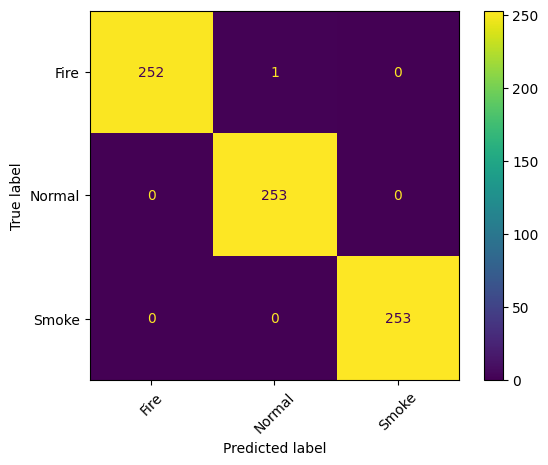

In [20]:
# Compute and visualize the confusion matrix with results from the trained model
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = ['Fire', 'Normal', 'Smoke']
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)

In [21]:
# Upload the model to the Hub to make it accesible and public
trainer.save_model()

In [22]:
from transformers import pipeline
from PIL import Image

image = Image.open("./APP/fog.jpeg")
pipeline = pipeline(task="image-classification", model="EdBianchi/vit-fire-detection")
predictions = pipeline(image)

In [23]:
predictions

[{'score': 0.9969804883003235, 'label': 'Normal'},
 {'score': 0.002715625800192356, 'label': 'Fire'},
 {'score': 0.0003038903814740479, 'label': 'Smoke'}]

In [24]:
image.show()